<h1>
🐝 Projet ML/IA - 'To bee or not to bee'

<h3>1. Imports & Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from skimage.io import imread, imsave
from skimage.measure import regionprops, label, moments_hu
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import rotate
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from scipy.ndimage import distance_transform_edt
from scipy.optimize import minimize
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8')

<h3>2. Load data and setup paths

In [2]:
image_dir = 'train/'
mask_dir = 'train/masks/'
cropped_dir = 'cropped/'
cropped_masks_dir = 'cropped/masks/'
inscribed_circles_dir = 'circles/'
symmetry_axes_dir = 'symmetry_axes/'
test_image_dir = 'test/'  # For images 251-347
test_mask_dir = 'test/masks/'
extracted_features_file = 'extracted_features.csv'

<h5> Load data and display basic stats

In [3]:
try:
    label_df = pd.read_excel('classif.xlsx')
    print("Classification file loaded successfully")
    print(f"Number of training samples: {len(label_df)}")
    print("\nBug type distribution:")
    print(label_df['bug type'].value_counts())
    print("\nSpecies distribution:")
    print(label_df['species'].value_counts())
except Exception as e:
    print(f"Error loading classification file: {e}")

Classification file loaded successfully
Number of training samples: 250

Bug type distribution:
bug type
Bee                115
Bumblebee          100
Butterfly           15
Hover fly            9
Wasp                 9
Dragonfly            1
Bee & Bumblebee      1
Name: count, dtype: int64

Species distribution:
species
Bombus hortorum                              71
Apis mellifera                               58
Bombus pascuorum                             25
Anthidium manicatum                          19
Megachile centuncularis                      17
Eristalis                                     9
Vespula germanica                             8
Anthidium                                     6
Macroglossum stellatarum                      5
Andrenidae                                    4
Pieris rapae                                  4
Aglais urticae                                3
Thyreus                                       3
Polyommatus icarus                            2
Bombu

<h3>3. Mask Pre-Processing and Feature Extraction Functions

In [4]:
def preprocess_mask(mask_path, image_path=None, save_id=None):
    """
    Clean mask and crop iamge and mask to the bounding box
    """
    mask = imread(mask_path, as_gray=True) > 0
    labeled = label(mask)
    props = regionprops(labeled)

    if not props:
        return None, None

    largest = max(props, key=lambda x: x.area)
    clean_mask = labeled == largest.label
    minr, minc, maxr, maxc = largest.bbox
    cropped_mask = clean_mask[minr:maxr, minc:maxc]

    if image_path:
        image = imread(image_path)
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        cropped_image = image[minr:maxr, minc:maxc]
    else:
        cropped_image = None
        
    if save_id is not None:
        imsave(f'{cropped_masks_dir}cropped_mask_{save_id}.png', img_as_ubyte(cropped_mask.astype(bool)))
        if cropped_image is not None:
            imsave(f'{cropped_dir}cropped_image_{save_id}.png', img_as_ubyte(cropped_image))

    return cropped_mask, cropped_image

def find_best_inscribed_circle(binary_mask):
    """
    Return x, y and radius of the largest inscribed cricle in the mask.
    """
    distance = distance_transform_edt(binary_mask)
    centroid = np.array(regionprops(label(binary_mask))[0].centroid)

    def neg_radius(params):
        x, y = params
        if 0 <= int(y) < distance.shape[0] and 0 <= int(x) < distance.shape[1]:
            return -distance[int(y), int(x)]
        return 1e6

    result = minimize(neg_radius, x0=centroid[::-1],
                      bounds=[(0, binary_mask.shape[1]), (0, binary_mask.shape[0])])
    best_x, best_y = result.x
    best_radius = distance[int(best_y), int(best_x)]
    return best_x, best_y, best_radius

def create_circular_mask(shape, center, radius):
    """
    Xreate a mask based on the associated inscribed circle
    """
    h, w = shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

def save_inscribed_circle_overlay(image, center_x, center_y, radius, save_path):
    """
    Draw and save inscribed cricle
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)
    circle = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def vertical_symmetry_loss(angle, image, xc, yc, mask=None):
    angle = float(angle)  
    rotated = rotate(image, angle, resize=False, center=(xc, yc), preserve_range=True)
    flipped = rotated[:, ::-1, ...]
    difference = (rotated - flipped) ** 2
    if mask is not None:
        mask_rot = rotate(mask.astype(float), angle, resize=False, center=(xc, yc), preserve_range=True)
        return np.mean(difference[mask_rot > 0.5])
    return np.mean(difference)

def find_best_symmetry_angle(image, center_x, center_y, mask=None):
    result = minimize(vertical_symmetry_loss, x0=0, args=(image, center_x, center_y, mask), bounds=[(-45, 45)])
    return result.x[0]

def save_symmetry_axis_overlay(image, center_x, center_y, angle, save_path):
    """
    DIsplay and saves the symmetry axis of the image
    """
    rotated = rotate(image, angle, resize=False, center=(center_x, center_y), preserve_range=True)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(rotated.astype(np.uint8))
    ax.axvline(center_x, color='cyan', linestyle='--', linewidth=2, label="Symmetry Axis")
    ax.set_title(f"Symmetry axis at angle {angle:.2f}°")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def extract_comprehensive_features(image_path, mask_path, img_id=None):
    """
    Extract images / mask features.
    Project requirements and personnal additions
    """
    try:
        # REQUIRED : Load cropped image and mask
        mask, image = preprocess_mask(mask_path, image_path, img_id)
        if mask is None or image is None:
            return None
        
        # Ensure image is 3D (RGB)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=2)
        
        # Get region properties
        labeled_mask = label(mask.astype(int))
        props = regionprops(labeled_mask)
        
        features = {}
        
        # REQUIRED: Inscribed circle
        try:
            cx, cy, radius = find_best_inscribed_circle(mask)
            features['inscribed_circle_radius'] = radius
            circle_path = f'{inscribed_circles_dir}circle_{img_id}.png'
            save_inscribed_circle_overlay(image, cx, cy, radius, circle_path)
        except:
            features['inscribed_circle_radius'] = 0

        # REQUIRED: Vertical symetry
        try:
            symmetry_angle = find_best_symmetry_angle(image, cx, cy, mask)
            features['symmetry_angle'] = symmetry_angle
            symmetry_path = f'{symmetry_axes_dir}symmetry_{img_id}.png'
            save_symmetry_axis_overlay(image, cx, cy, symmetry_angle, symmetry_path)
        except Exception as e:
            print(f"[ERROR] Failed to compute symmetry for ID {img_id}: {e}")
            features['symmetry_angle'] = 0
        
        # REQUIRED: Area ratio (pixels of bug / pixels of full image)
        total_pixels = mask.shape[0] * mask.shape[1]
        bug_pixels = np.sum(mask)
        features['area_ratio'] = bug_pixels / total_pixels
        
        # REQUIRED: RGB statistics within bug mask
        for i, color in enumerate(['R', 'G', 'B']):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[mask]
                if len(values) > 0:
                    features[f'{color}_min'] = np.min(values)
                    features[f'{color}_max'] = np.max(values)
                    features[f'{color}_mean'] = np.mean(values)
                    features[f'{color}_median'] = np.median(values)
                    features[f'{color}_std'] = np.std(values)
                else:
                    # Handle empty mask case
                    for stat in ['min', 'max', 'mean', 'median', 'std']:
                        features[f'{color}_{stat}'] = 0
                        
        # ADDITIONAL: RGB statistics within inscibed circle mask
        circle_mask = create_circular_mask(mask.shape, (cx, cy), radius)
        for i, (color, stat) in enumerate([('R', 'mean'),('G', 'std'),('B', 'median')]):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[circle_mask]
                if len(values):
                    if stat == 'mean':
                        features[f'circle_{color}_{stat}'] = np.mean(values)
                    elif stat == 'std':
                        features[f'circle_{color}_{stat}'] = np.std(values)
                    elif stat == 'median':
                        features[f'circle_{color}_{stat}'] = np.median(values)
                else:
                    features[f'circle_{color}_{stat}'] = 0
            
        # ADDITIONAL: Shape and symmetry measures features
        if props:
            prop = props[0]  # Take the largest connected component

            features['aspect_ratio'] = prop.major_axis_length / max(prop.minor_axis_length, 1e-6)
            features['eccentricity'] = prop.eccentricity
            features['compactness'] = (prop.perimeter ** 2) / max(prop.area, 1e-6)
            features['roundness'] = (4 * np.pi * prop.area) / max(prop.perimeter ** 2, 1e-6)
            features['orientation'] = prop.orientation
            features['solidity'] = prop.solidity
            
        else:
            # Default values if no region found
            shape_features = ['eccentricity', 'solidity', 'aspect_ratio', 'compactness', 'roundness', 'orientation']
            for feat in shape_features:
                features[feat] = 0
                
        # ADDITIONAL: Other features
        # Hu Moments
        try:
            hu = moments_hu(mask.astype(float))
            for i, val in enumerate(hu):
                features[f'hu_moment_{i+1}'] = val
        except:
            for i in range(7):
                features[f'hu_moment_{i+1}'] = 0

        # Edge Density
        try:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
            edges = sobel(gray_image)
            features['edge_density'] = np.sum(edges[mask]) / max(np.sum(mask), 1)
        except:
            features['edge_density'] = 0

        # Texture (GLCM)
        try:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
            region = gray_image * mask
            region_quant = (region / 255 * 32).astype(np.uint8)
            glcm = graycomatrix(region_quant, [1], [0], levels=32, symmetric=True, normed=True)
            features['glcm_contrast'] = graycoprops(glcm, 'contrast')[0, 0]
            features['glcm_homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
            features['glcm_energy'] = graycoprops(glcm, 'energy')[0, 0]
            features['glcm_dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
        except:
            for feat in ['contrast', 'homogeneity', 'energy', 'dissimilarity']:
                features[f'glcm_{feat}'] = 0
        
        return features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

<h3>4. Extract features from training set</h3>

In [5]:
print("Extracting features from training images...")
feature_list = []
failed_extractions = []
if os.path.exists(extracted_features_file):
    print(f"Loading existing features from {extracted_features_file}")
    feature_list = pd.read_csv(extracted_features_file).to_dict(orient='records')

else:
    print("No existing features found, extracting from scratch.")
    for i, row in label_df.iterrows():
        img_id = row['ID']
        img_path = os.path.join(image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(mask_dir, f"binary_{img_id}.tif")
        
        # We make sure to check if image and mask exist for each ID
        try:
            if not os.path.exists(img_path):
                print(f"[WARNING] Image missing: {img_path}")
                failed_extractions.append(img_id)
                continue
            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask missing: {mask_path}")
                failed_extractions.append(img_id)
                continue
            
            features = extract_comprehensive_features(img_path, mask_path, img_id)
            if features is not None:
                features['ID'] = img_id
                features['bug_type'] = row['bug type']
                features['species'] = row['species']
                feature_list.append(features)
            else:
                failed_extractions.append(img_id)
                
        except Exception as e:
            print(f"[ERROR] Problem with ID {img_id}: {e}")
            failed_extractions.append(img_id)

Extracting features from training images...
Loading existing features from extracted_features.csv


<h3> Storing extracted features into a pandas dataframe and extracting into csv format

In [6]:
df_features = pd.DataFrame(feature_list)
print(f"\nFeature extraction completed!")
print(f"Successfully processed: {len(df_features)} images")
print(f"Failed extractions: {len(failed_extractions)} images")
print(f"Feature dimensions: {df_features.shape}")

# Display basic statistics
print("\n=== FEATURE SUMMARY ===")
feature_cols = [col for col in df_features.columns if col not in ['ID', 'bug_type', 'species']]
print(f"Total features extracted: {len(feature_cols)}")
print("\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")

# Save features to CSV 
df_features.to_csv('extracted_features.csv', index=False)
print("\nFeatures saved to 'extracted_features.csv'")

print("\n=== SAMPLE DATA ===")
print(df_features.head())


Feature extraction completed!
Successfully processed: 249 images
Failed extractions: 0 images
Feature dimensions: (249, 42)

=== FEATURE SUMMARY ===
Total features extracted: 39

Feature list:
 1. inscribed_circle_radius
 2. symmetry_angle
 3. area_ratio
 4. R_min
 5. R_max
 6. R_mean
 7. R_median
 8. R_std
 9. G_min
10. G_max
11. G_mean
12. G_median
13. G_std
14. B_min
15. B_max
16. B_mean
17. B_median
18. B_std
19. circle_R_mean
20. circle_G_std
21. circle_B_median
22. aspect_ratio
23. eccentricity
24. compactness
25. roundness
26. orientation
27. solidity
28. hu_moment_1
29. hu_moment_2
30. hu_moment_3
31. hu_moment_4
32. hu_moment_5
33. hu_moment_6
34. hu_moment_7
35. edge_density
36. glcm_contrast
37. glcm_homogeneity
38. glcm_energy
39. glcm_dissimilarity

Features saved to 'extracted_features.csv'

=== SAMPLE DATA ===
   inscribed_circle_radius  symmetry_angle  area_ratio  R_min  R_max  \
0               128.128841       45.000000    0.506544      5    208   
1               10

<h3>Correlation matrix to visualize high correlated features

All columns in the dataset:
['inscribed_circle_radius', 'symmetry_angle', 'area_ratio', 'R_min', 'R_max', 'R_mean', 'R_median', 'R_std', 'G_min', 'G_max', 'G_mean', 'G_median', 'G_std', 'B_min', 'B_max', 'B_mean', 'B_median', 'B_std', 'circle_R_mean', 'circle_G_std', 'circle_B_median', 'aspect_ratio', 'eccentricity', 'compactness', 'roundness', 'orientation', 'solidity', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7', 'edge_density', 'glcm_contrast', 'glcm_homogeneity', 'glcm_energy', 'glcm_dissimilarity', 'ID', 'bug_type', 'species']


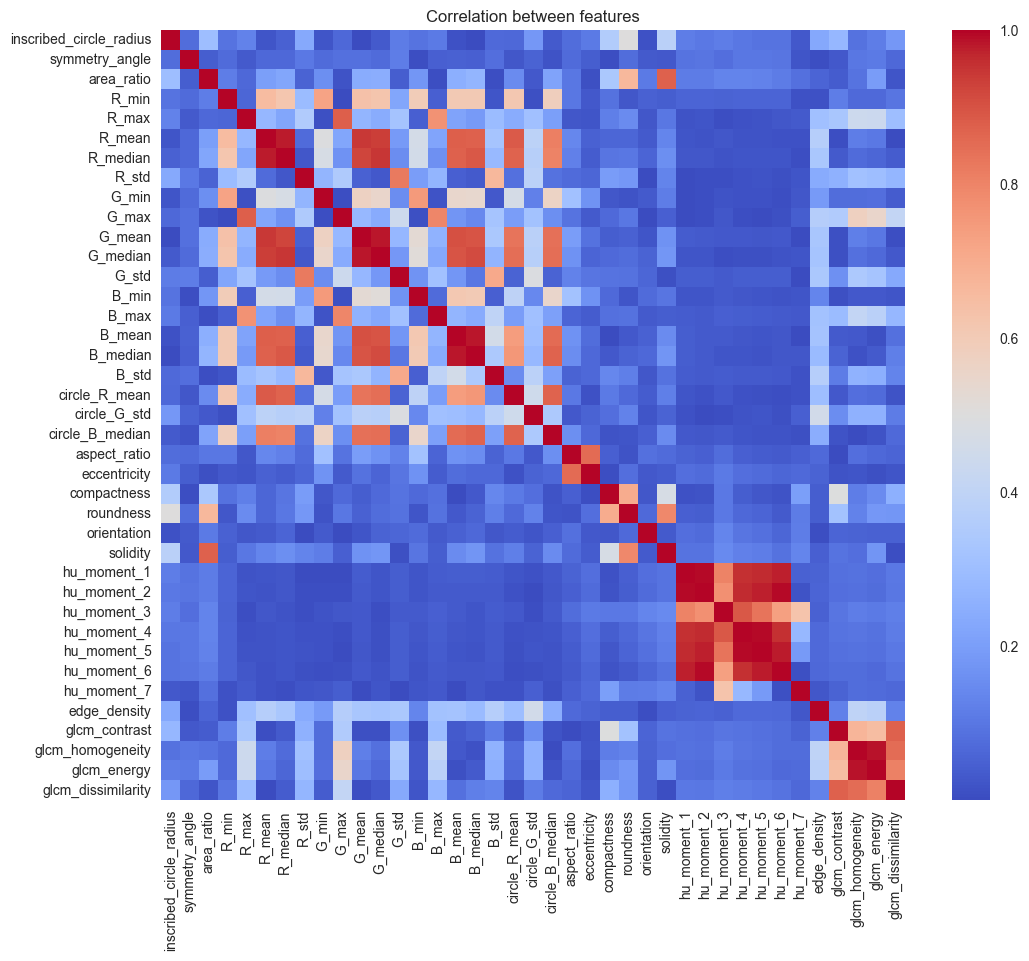

In [7]:
# Load the features that were previously extracted
df = df_features.copy()

# Show all available columns (features + metadata)
print("All columns in the dataset:")
print(df.columns.tolist())

# Keep only feature columns (remove ID and labels)
feature_cols = [col for col in df.columns if col not in ['ID', 'bug_type', 'species']]
X = df[feature_cols]

# Calculate absolute correlation between features
corr_matrix = X.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()

<h3>Removing highly correlated features

<h5>a) removing features with high correlation

In [8]:
# Drop one of each pair of features with correlation > 0.95
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

print(f"\nHighly correlated features (to be removed): {to_drop}")

# Drop them
X_filtered = X.drop(columns=to_drop)  

# Combine with labels again for further training
df_cleaned = pd.concat([df[['ID', 'bug_type', 'species']], X_filtered], axis=1)
optimized_feature_cols = X_filtered.columns.tolist()


Highly correlated features (to be removed): ['R_median', 'G_median', 'B_median', 'hu_moment_2', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'glcm_energy']


<h3>b) comparing full set performances on random forest with filtered set

In [9]:
X_full = df[feature_cols]
y = df['bug_type']

scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full_scaled, y, test_size=0.2, random_state=42)

rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train_f, y_train_f)
y_pred_f = rf_full.predict(X_test_f)

print("Results with full feature set:")
print("Accuracy:", accuracy_score(y_test_f, y_pred_f))
print(classification_report(y_test_f, y_pred_f))

# optimized feature set
X_reduced = X_filtered
scaler_red = StandardScaler()
X_red_scaled = scaler_red.fit_transform(X_reduced)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_red_scaled, y, test_size=0.2, random_state=42)

rf_red = RandomForestClassifier(n_estimators=100, random_state=42)
rf_red.fit(X_train_r, y_train_r)
y_pred_r = rf_red.predict(X_test_r)

print("\nResults with optimized feature set:")
print("Accuracy:", accuracy_score(y_test_r, y_pred_r))
print(classification_report(y_test_r, y_pred_r))

Results with full feature set:
Accuracy: 0.68
              precision    recall  f1-score   support

         Bee       0.75      0.80      0.77        30
   Bumblebee       0.56      0.67      0.61        15
   Butterfly       0.00      0.00      0.00         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.68        50
   macro avg       0.26      0.29      0.28        50
weighted avg       0.62      0.68      0.65        50


Results with optimized feature set:
Accuracy: 0.68
              precision    recall  f1-score   support

         Bee       0.73      0.80      0.76        30
   Bumblebee       0.59      0.67      0.62        15
   Butterfly       0.00      0.00      0.00         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.68        50
   macro avg       0.26      0.29

<h3> 5. Data Visualisation </h3>
<h5> 5.1 Bug type and species distribution

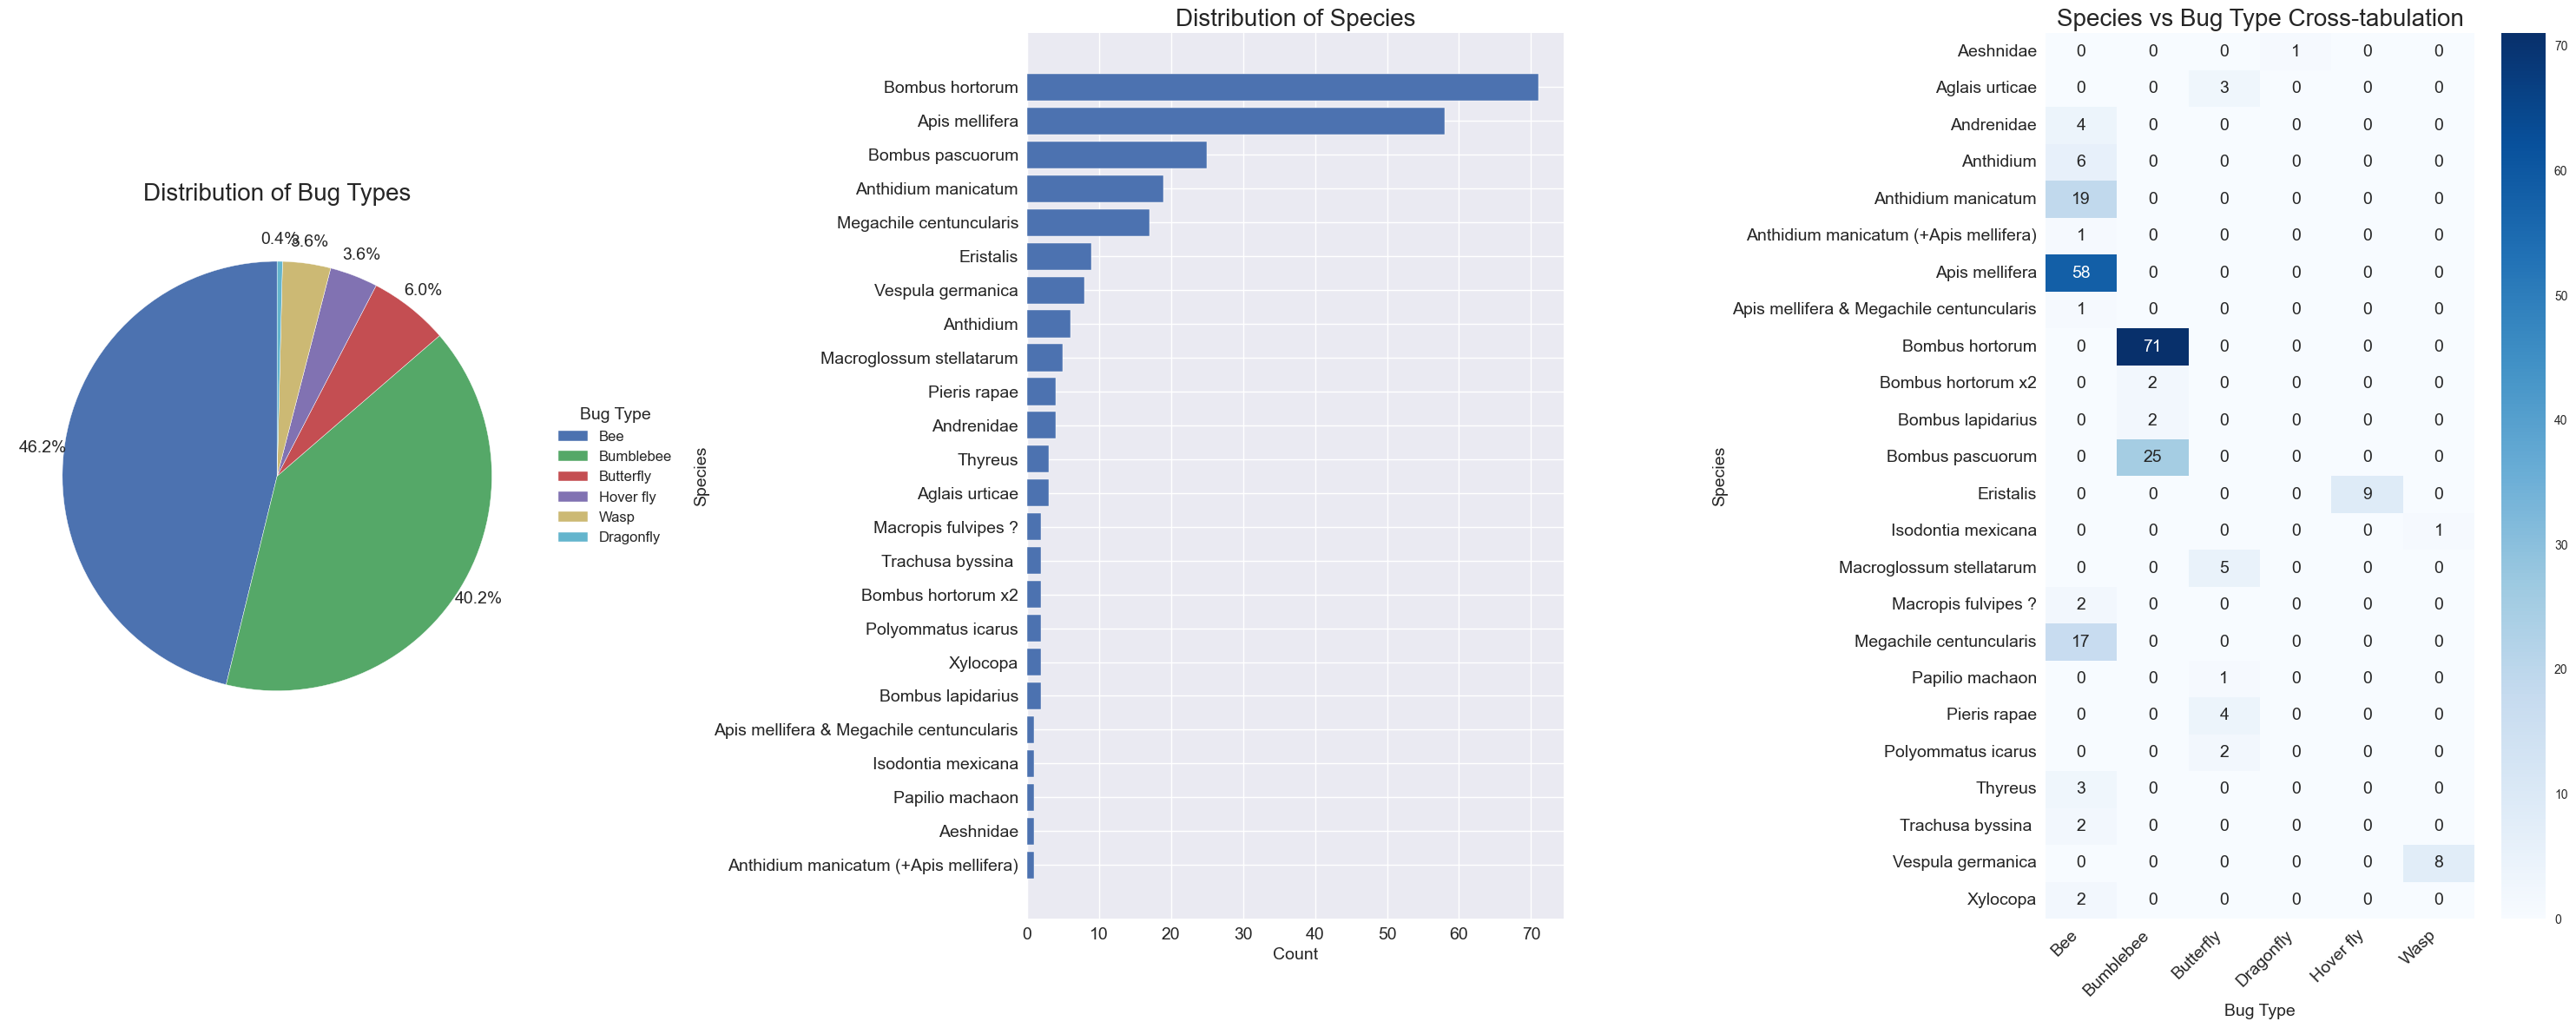

In [13]:
plt.figure(figsize=(30, 12))

plt.subplot(1, 3, 1)
bug_counts = df_features['bug_type'].value_counts()
wedges, texts, autotexts = plt.pie( bug_counts.values, labels=None, autopct='%1.1f%%', startangle=90, pctdistance=1.1, textprops={'fontsize': 14})
for autotext in autotexts:
    autotext.set_horizontalalignment('center')

plt.legend(wedges, bug_counts.index, title="Bug Type", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title_fontsize=14)
plt.title('Distribution of Bug Types', fontsize=20)

plt.subplot(1, 3, 2)
species_counts = df_features['species'].value_counts().sort_values(ascending=True)
plt.barh(range(len(species_counts)), species_counts.values)
plt.yticks(range(len(species_counts)), species_counts.index, fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Species', fontsize=14)
plt.title('Distribution of Species', fontsize=20)

#cross-tabulation
plt.subplot(1, 3, 3)
ct = pd.crosstab(df_features['bug_type'], df_features['species']).T
ax = sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.xlabel("Bug Type", fontsize=14)
plt.ylabel("Species", fontsize=14)
plt.title("Species vs Bug Type Cross-tabulation", fontsize=20)

plt.tight_layout()
plt.show()

<h5>5.2 PCA Projection 

In [34]:
# Prepare data for full features set
X = df_features[feature_cols].fillna(0)
y_bug_type = df_features['bug_type']
y_species = df_features['species']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare data for reduced features set
X_reduced = df_cleaned[optimized_feature_cols].fillna(0)
X_reduced_scaled = scaler.fit_transform(X_reduced)


=== PCA ANALYSIS ===
PCA Variance explained by first 2 components: [0.21282208 0.16375244]
Total variance explained: 0.377


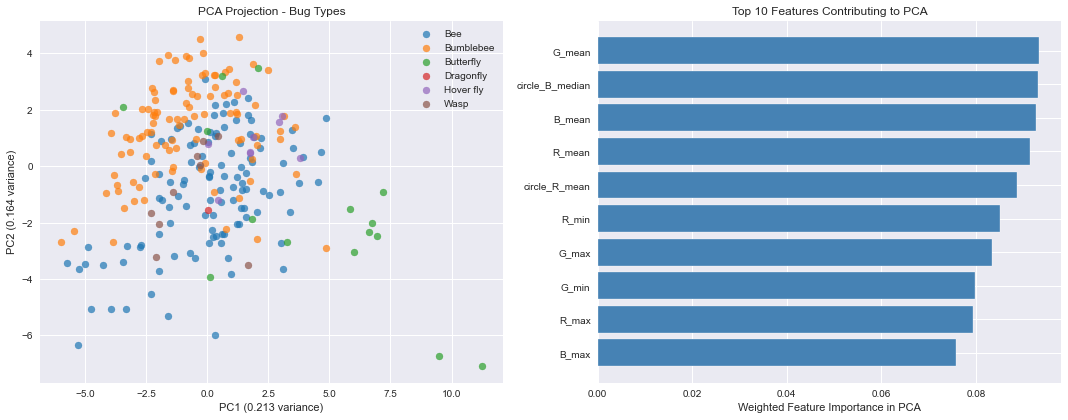

In [35]:
print("\n=== PCA ANALYSIS ===")

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reduced_scaled)

print(f"PCA Variance explained by first 2 components: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Plot PCA results

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

classes = sorted(y_bug_type.unique())  
colors = plt.cm.tab10.colors

for i, cls in enumerate(classes):
    mask = (y_bug_type == cls)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA Projection - Bug Types')

# Add legend

plt.legend()
plt.subplot(1, 2, 2)

weighted_importance = np.sum(
    np.abs(pca.components_) * pca.explained_variance_ratio_[:, np.newaxis],
    axis=0
)

# Sélection des top 10 features
top_features_idx = np.argsort(weighted_importance)[-10:][::-1]
top_features = [optimized_feature_cols[i] for i in top_features_idx]
top_importance = weighted_importance[top_features_idx]

plt.barh(range(len(top_features))[::-1], top_importance, color='steelblue')
plt.yticks(range(len(top_features))[::-1], top_features)
plt.xlabel('Weighted Feature Importance in PCA')
plt.title('Top 10 Features Contributing to PCA')

plt.tight_layout()
plt.show()

<h5>5.3 Non-linear projections 


=== NON-LINEAR PROJECTIONS ===
Computing t-SNE projection...
UMAP not available, using Isomap instead...


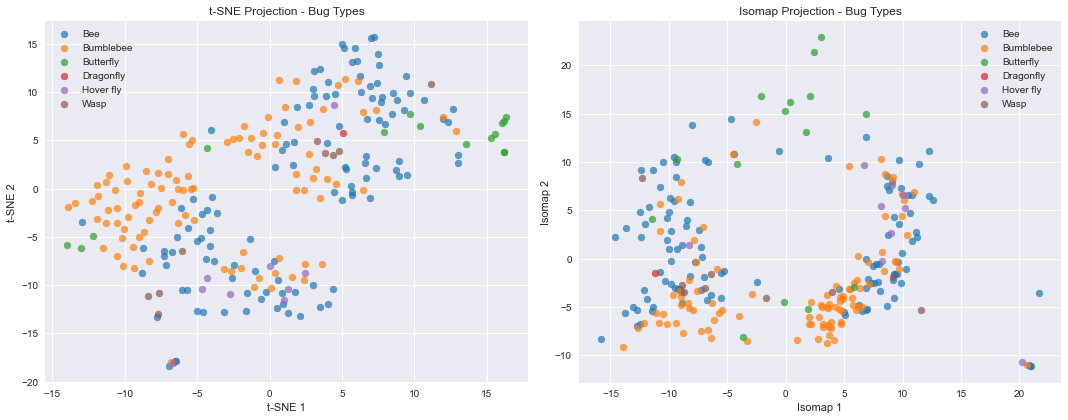

In [36]:
print("\n=== NON-LINEAR PROJECTIONS ===")

# t-SNE projection
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
X_tsne = tsne.fit_transform(X_scaled)

# UMAP projection (if available, otherwise use another method)
try:
    from umap import UMAP
    print("Computing UMAP projection...")
    umap_reducer = UMAP(n_components=2, random_state=42)
    X_umap = umap_reducer.fit_transform(X_scaled)
    has_umap = True
except ImportError:
    print("UMAP not available, using Isomap instead...")
    from sklearn.manifold import Isomap
    isomap = Isomap(n_components=2)
    X_umap = isomap.fit_transform(X_scaled)
    has_umap = False

# Plot non-linear projections
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

for i, cls in enumerate(classes):
    mask = (y_bug_type == cls)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection - Bug Types')
plt.legend()

plt.subplot(1, 2, 2)

for i, cls in enumerate(classes):
    mask = (y_bug_type == cls)
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)
    
plt.xlabel('UMAP 1' if has_umap else 'Isomap 1')
plt.ylabel('UMAP 2' if has_umap else 'Isomap 2')
plt.title(f'{"UMAP" if has_umap else "Isomap"} Projection - Bug Types')
plt.legend()

plt.tight_layout()
plt.show()

<h3>6. Machine Learning Algorithms

<h5>Data preparation

In [37]:
# Prepare data
X_ml = df_features[feature_cols].fillna(0)
y_ml = df_features['bug_type']

le = LabelEncoder()
y_encoded = le.fit_transform(y_ml)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_encoded, test_size=0.2, random_state=42) # enlevé stratify parce que certaines classes < 2

# Standardize features
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

<h5>6.1 Supervised Methods</h5>
<h7>Method 1: Support Vector Machine

In [38]:
print("\n--- SVM Classifier ---")
svm_clf = SVC(random_state=42, class_weight='balanced')
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)

print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))


--- SVM Classifier ---
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        30
           1       0.75      0.80      0.77        15
           2       0.50      0.50      0.50         2
           4       0.33      1.00      0.50         2
           5       1.00      1.00      1.00         1

    accuracy                           0.74        50
   macro avg       0.68      0.80      0.71        50
weighted avg       0.78      0.74      0.75        50

SVM Confusion Matrix:
[[21  4  1  4  0]
 [ 3 12  0  0  0]
 [ 1  0  1  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0  1]]


<h7>Method 2: K-Nearest Neighbors

In [39]:
print("\n--- KNN Classifier ---")
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)
knn_pred = knn_clf.predict(X_test_scaled)

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, knn_pred))


--- KNN Classifier ---
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.60      0.69        30
           1       0.44      0.73      0.55        15
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         2
           5       0.50      1.00      0.67         1

    accuracy                           0.62        50
   macro avg       0.55      0.57      0.52        50
weighted avg       0.67      0.62      0.62        50

KNN Confusion Matrix:
[[18 12  0  0  0]
 [ 3 11  0  0  1]
 [ 1  0  1  0  0]
 [ 0  2  0  0  0]
 [ 0  0  0  0  1]]


<h7>Method 3: Logistic regression

In [40]:
print("\n--- Logistic Regression ---")
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_scaled, y_train)
lr_pred = lr_clf.predict(X_test_scaled)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_pred))


--- Logistic Regression ---
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.71      0.80      0.75        15
           2       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         2
           5       0.50      1.00      0.67         1

    accuracy                           0.76        50
   macro avg       0.48      0.62      0.53        50
weighted avg       0.75      0.76      0.75        50

Logistic Regression Confusion Matrix:
[[24  4  1  0  1]
 [ 3 12  0  0  0]
 [ 1  0  1  0  0]
 [ 0  1  1  0  0]
 [ 0  0  0  0  1]]


<h7>Linear discriminant analysis

In [41]:
print("\n--- LDA Classifier ---")
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train_scaled, y_train)
lda_pred = lda_clf.predict(X_test_scaled)

print("LDA Classification Report:")
print(classification_report(y_test, lda_pred))
print("LDA Confusion Matrix:")
print(confusion_matrix(y_test, lda_pred))


--- LDA Classifier ---
LDA Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.71      0.80      0.75        15
           2       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         2
           5       0.50      1.00      0.67         1

    accuracy                           0.76        50
   macro avg       0.48      0.62      0.53        50
weighted avg       0.75      0.76      0.75        50

LDA Confusion Matrix:
[[24  4  1  0  1]
 [ 3 12  0  0  0]
 [ 1  0  1  0  0]
 [ 0  1  1  0  0]
 [ 0  0  0  0  1]]


<h7>Naive Bayes (GaussianNB)

In [54]:
print("\n--- Naive Bayes Classifier ---")
nb_clf = GaussianNB()
nb_clf.fit(X_train_scaled, y_train)
nb_pred = nb_clf.predict(X_test_scaled)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, nb_pred))


--- Naive Bayes Classifier ---
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.13      0.22        30
           1       0.60      0.20      0.30        15
           2       0.03      0.50      0.06         2
           4       0.00      0.00      0.00         2
           5       0.25      1.00      0.40         1

    accuracy                           0.18        50
   macro avg       0.29      0.37      0.19        50
weighted avg       0.53      0.18      0.23        50

Naive Bayes Confusion Matrix:
[[ 4  2 22  0  2]
 [ 2  3  9  0  1]
 [ 1  0  1  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0  0  1]]


<h7>NLP classifier

In [55]:
print("\n--- MLP Classifier ---")
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_clf.fit(X_train_scaled, y_train)
mlp_pred = mlp_clf.predict(X_test_scaled)

print("MLP Classification Report:")
print(classification_report(y_test, mlp_pred))
print("MLP Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))


--- MLP Classifier ---
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.60      0.80      0.69        15
           2       0.25      0.50      0.33         2
           4       0.00      0.00      0.00         2
           5       0.50      1.00      0.67         1

    accuracy                           0.68        50
   macro avg       0.44      0.59      0.49        50
weighted avg       0.70      0.68      0.68        50

MLP Confusion Matrix:
[[20  7  2  0  1]
 [ 3 12  0  0  0]
 [ 1  0  1  0  0]
 [ 0  1  1  0  0]
 [ 0  0  0  0  1]]


<h7>Ridge classifier

In [60]:
print("\n--- Ridge Classifier ---")
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train_scaled, y_train)
ridge_pred = ridge_clf.predict(X_test_scaled)

print("Ridge Classification Report:")
print(classification_report(y_test, ridge_pred))
print("Ridge Confusion Matrix:")
print(confusion_matrix(y_test, ridge_pred))


--- Ridge Classifier ---
Ridge Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.63      0.80      0.71        15
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.74        50
   macro avg       0.49      0.42      0.44        50
weighted avg       0.73      0.74      0.73        50

Ridge Confusion Matrix:
[[24  5  0  0  1]
 [ 3 12  0  0  0]
 [ 1  0  1  0  0]
 [ 0  2  0  0  0]
 [ 1  0  0  0  0]]


<h5>6.2 Ensemble Learning Method 

<h7> Random forest


--- Random Forest Classifier (Ensemble) ---


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        30
           1       0.56      0.67      0.61        15
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.68        50
   macro avg       0.26      0.29      0.28        50
weighted avg       0.62      0.68      0.65        50

Random Forest Confusion Matrix:
[[24  6  0  0  0]
 [ 5 10  0  0  0]
 [ 2  0  0  0  0]
 [ 0  2  0  0  0]
 [ 1  0  0  0  0]]


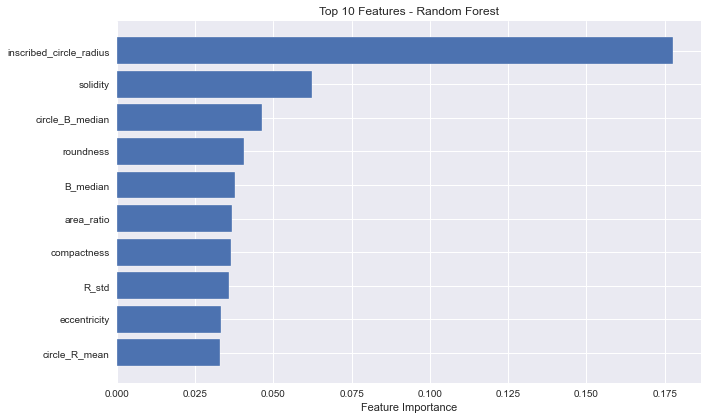

In [42]:
print("\n--- Random Forest Classifier (Ensemble) ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)  # RF can handle unscaled data
rf_pred = rf_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

# Feature importance from Random Forest
feature_importance_rf = rf_clf.feature_importances_
top_features_rf_idx = np.argsort(feature_importance_rf)[-10:]
top_features_rf = [feature_cols[i] for i in top_features_rf_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_rf)), feature_importance_rf[top_features_rf_idx])
plt.yticks(range(len(top_features_rf)), top_features_rf)
plt.xlabel('Feature Importance')
plt.title('Top 10 Features - Random Forest')
plt.tight_layout()
plt.show()

<h7> XGBoost

In [57]:
print("\n--- XGBoost Classifier ---")
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_scaled, y_train)
xgb_pred = xgb_clf.predict(X_test_scaled)

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))


--- XGBoost Classifier ---
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        30
           1       0.71      0.67      0.69        15
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.72        50
   macro avg       0.29      0.31      0.30        50
weighted avg       0.66      0.72      0.69        50

XGBoost Confusion Matrix:
[[26  4  0  0  0]
 [ 5 10  0  0  0]
 [ 2  0  0  0  0]
 [ 1  0  1  0  0]
 [ 1  0  0  0  0]]


<h7>Catboost

In [59]:
print("\n--- CatBoost Classifier ---")
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train_scaled, y_train)
cat_pred = cat_clf.predict(X_test_scaled)

print("CatBoost Classification Report:")
print(classification_report(y_test, cat_pred))
print("CatBoost Confusion Matrix:")
print(confusion_matrix(y_test, cat_pred))


--- CatBoost Classifier ---
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.53      0.67      0.59        15
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         2
           5       1.00      1.00      1.00         1

    accuracy                           0.70        50
   macro avg       0.66      0.59      0.61        50
weighted avg       0.69      0.70      0.69        50

CatBoost Confusion Matrix:
[[23  7  0  0  0]
 [ 5 10  0  0  0]
 [ 1  0  1  0  0]
 [ 0  2  0  0  0]
 [ 0  0  0  0  1]]


<h7> Voting classifier

In [44]:
print("\n--- Voting Classifier (Ensemble) ---")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42, class_weight='balanced')),
        ('knn', KNeighborsClassifier())
    ],
    voting='soft'  # 'hard' for main classes, 'soft' for probabilities
)

voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

print("Voting Classification Report:")
print(classification_report(y_test, voting_pred))
print("Voting Confusion Matrix:")
print(confusion_matrix(y_test, voting_pred))


--- Voting Classifier (Ensemble) ---
Voting Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        30
           1       0.48      0.73      0.58        15
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.64        50
   macro avg       0.45      0.38      0.39        50
weighted avg       0.65      0.64      0.63        50

Voting Confusion Matrix:
[[20 10  0  0  0]
 [ 4 11  0  0  0]
 [ 1  0  1  0  0]
 [ 0  2  0  0  0]
 [ 1  0  0  0  0]]


<h7> Stacking classifier

In [45]:
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]

meta_model = GradientBoostingClassifier()

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5  
)

stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

print("Stacking Classification Report:")
print(classification_report(y_test, stacking_pred))
print("Stacking Confusion Matrix:")
print(confusion_matrix(y_test, stacking_pred))

Stacking Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        30
           1       0.50      0.67      0.57        15
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.58        50
   macro avg       0.24      0.26      0.25        50
weighted avg       0.56      0.58      0.56        50

Stacking Confusion Matrix:
[[19 10  1  0  0]
 [ 5 10  0  0  0]
 [ 2  0  0  0  0]
 [ 1  0  1  0  0]
 [ 1  0  0  0  0]]


<h5>6.3 Clustering Methods

<h7>Method 1: K-Means Clustering

In [46]:
print("\n--- K-Means Clustering ---")
n_clusters = len(df_features['bug_type'].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")


--- K-Means Clustering ---
K-Means Silhouette Score: 0.128


<h7>Method 2: DBSCAN Clustering

In [47]:
print("\n--- DBSCAN Clustering ---")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN - Estimated clusters: {n_clusters_dbscan}")
print(f"DBSCAN - Noise points: {n_noise}")

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")


--- DBSCAN Clustering ---
DBSCAN - Estimated clusters: 0
DBSCAN - Noise points: 249


<h7>Method 3: Hierarchical Clustering

In [48]:
print("\n--- Hierarchical Clustering ---")
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.3f}")


--- Hierarchical Clustering ---
Hierarchical Silhouette Score: 0.124


<h7>Plot clustering results

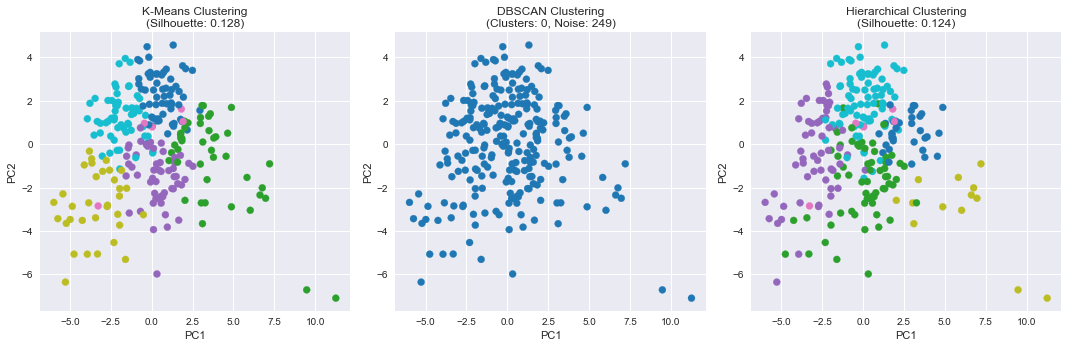

In [49]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
plt.title(f'K-Means Clustering\n(Silhouette: {kmeans_silhouette:.3f})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10')
plt.title(f'DBSCAN Clustering\n(Clusters: {n_clusters_dbscan}, Noise: {n_noise})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='tab10')
plt.title(f'Hierarchical Clustering\n(Silhouette: {hierarchical_silhouette:.3f})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

<h5>6.4 Hyperparameter Optimization 

<h7> Grid Search for SVM

In [50]:
print("\n--- SVM with Grid Search ---")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train_scaled, y_train)

print(f"Best SVM parameters: {svm_grid_search.best_params_}")
print(f"Best SVM score: {svm_grid_search.best_score_:.3f}")

# Test best SVM
best_svm = svm_grid_search.best_estimator_
best_svm_pred = best_svm.predict(X_test_scaled)
print("Optimized SVM Classification Report:")
print(classification_report(y_test, best_svm_pred))


--- SVM with Grid Search ---
Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM score: 0.804
Optimized SVM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.67      0.67      0.67        15
           2       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         2
           5       0.33      1.00      0.50         1

    accuracy                           0.72        50
   macro avg       0.43      0.59      0.48        50
weighted avg       0.72      0.72      0.71        50



<h7>Randomized Search for Random Forest  

In [51]:
print("\n--- Random Forest with Randomized Search ---")
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_dist, 
                                      n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
rf_random_search.fit(X_train, y_train)

print(f"Best RF parameters: {rf_random_search.best_params_}")
print(f"Best RF score: {rf_random_search.best_score_:.3f}")

# Test best Random Forest
best_rf = rf_random_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
print("Optimized RF Classification Report:")
print(classification_report(y_test, best_rf_pred))


--- Random Forest with Randomized Search ---
Best RF parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
Best RF score: 0.799
Optimized RF Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        30
           1       0.59      0.67      0.62        15
           2       0.50      0.50      0.50         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.70        50
   macro avg       0.37      0.39      0.38        50
weighted avg       0.66      0.70      0.68        50



<h3>7. Models comparison

In [61]:
print("\n=== MODEL COMPARISON ===")

models = {
    'SVM': (svm_clf, svm_pred),
    'KNN': (knn_clf, knn_pred),
    'Logistic Regression' : (lr_clf, lr_pred),
    'Linear Discriminant Analysis': (lda_clf, lda_pred),
    'Naive Bayes': (nb_clf, nb_pred),
    'MLP Classifier': (mlp_clf, mlp_pred),
    'Ridge Classifier': (ridge_clf, ridge_pred),
    'Random Forest': (rf_clf, rf_pred),
    'XGBoost' : (xgb_clf, xgb_pred),
    'CatBoost': (cat_clf, cat_pred),
    'Voting Classifier': (voting_clf, voting_pred),
    'Stacking Classifier': (stacking_clf, stacking_pred),
    'SVM (Optimized)': (best_svm, best_svm_pred),
    'RF (Optimized)': (best_rf, best_rf_pred)
}

print("Model Accuracy Comparison:")
print("-" * 40)
for name, (model, pred) in models.items():
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_test, pred)
    print(f"{name:30s}: Accuracy: {accuracy:.3f}, F1: {f1:.3f}, Recall: {recall:.3f}, Balanced Acc: {balanced_accuracy:.3f}")


=== MODEL COMPARISON ===
Model Accuracy Comparison:
----------------------------------------
SVM                           : Accuracy: 0.740, F1: 0.750, Recall: 0.740, Balanced Acc: 0.800
KNN                           : Accuracy: 0.620, F1: 0.620, Recall: 0.620, Balanced Acc: 0.567
Logistic Regression           : Accuracy: 0.760, F1: 0.751, Recall: 0.760, Balanced Acc: 0.620
Linear Discriminant Analysis  : Accuracy: 0.760, F1: 0.751, Recall: 0.760, Balanced Acc: 0.620
Naive Bayes                   : Accuracy: 0.180, F1: 0.230, Recall: 0.180, Balanced Acc: 0.367
MLP Classifier                : Accuracy: 0.680, F1: 0.677, Recall: 0.680, Balanced Acc: 0.593
Ridge Classifier              : Accuracy: 0.740, F1: 0.727, Recall: 0.740, Balanced Acc: 0.420
Random Forest                 : Accuracy: 0.680, F1: 0.646, Recall: 0.680, Balanced Acc: 0.293
XGBoost                       : Accuracy: 0.720, F1: 0.687, Recall: 0.720, Balanced Acc: 0.307
CatBoost                      : Accuracy: 0.700, F1

<h3>8. Prepare for test data processing

In [96]:
print("\n=== PREPARING FOR TEST DATA ===")

# Select best model based on performance
best_model_name = max(models.keys(), key=lambda k: accuracy_score(y_test, models[k][1]))
best_model = models[best_model_name][0]

print(f"Selected best model: {best_model_name}")
print(f"Best model accuracy: {accuracy_score(y_test, models[best_model_name][1]):.3f}")


=== PREPARING FOR TEST DATA ===
Selected best model: Logistic Regression
Best model accuracy: 0.760


<h5>8.1 Function to process test images (251 - 347)

In [ ]:
def process_test_images():
    """Process test images and generate predictions"""
    test_results = []
    
    # Assuming test images are numbered 251-347
    for img_id in range(251, 348):
        img_path = os.path.join(test_image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(test_mask_dir, f"binary_{img_id}.tif")
        
        if os.path.exists(img_path) and os.path.exists(mask_path):
            # Extract features
            features = extract_comprehensive_features(img_path, mask_path)
            if features is not None:
                # Remove non-feature columns
                feature_vector = [features.get(col, 0) for col in feature_cols]
                
                # Scale features using the same scaler
                if best_model_name in ['SVM', 'SVM (Optimized)', 'KNN']:
                    feature_vector_scaled = scaler_ml.transform([feature_vector])
                    prediction = best_model.predict(feature_vector_scaled)[0]
                else:
                    prediction = best_model.predict([feature_vector])[0]
                
                test_results.append({'ID': img_id, 'bug type': prediction})
    
    return test_results

<h5>8.2 Save preprocessing objects for use with test data

In [ ]:
import pickle

preprocessing_objects = {
    'scaler': scaler_ml,
    'feature_columns': feature_cols,
    'best_model': best_model,
    'best_model_name': best_model_name
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("Preprocessing objects saved for test data processing")

<h3> Summary

In [ ]:
print("\n=== PROJECT SUMMARY ===")
print(f"✓ Feature extraction completed: {len(feature_cols)} features")
print(f"✓ Data visualization: Distributions, PCA, t-SNE, {'UMAP' if has_umap else 'Isomap'}")
print(f"✓ Supervised methods: SVM, KNN")
print(f"✓ Ensemble method: Random Forest")
print(f"✓ Clustering methods: K-Means, DBSCAN, Hierarchical")
print(f"✓ Hyperparameter optimization: Grid Search (SVM), Randomized Search (RF)")
print(f"✓ Best model selected: {best_model_name}")